In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)


test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [5]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

## Arsitektur & Config

In [6]:
from jcopdl.layers import linear_block

In [16]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax"),
        )
        
    
    def forward(self, x):
        return self.fc(x)

In [9]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

## Training Preparation -> MCOC

In [10]:
config.n2

64

In [17]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7374 | Test_cost  = 0.4673 | Train_score = 0.7401 | Test_score = 0.8375 |




Epoch     2
Train_cost  = 0.4724 | Test_cost  = 0.3982 | Train_score = 0.8328 | Test_score = 0.8548 |




Epoch     3
Train_cost  = 0.4160 | Test_cost  = 0.3649 | Train_score = 0.8516 | Test_score = 0.8654 |




Epoch     4
Train_cost  = 0.3899 | Test_cost  = 0.3874 | Train_score = 0.8595 | Test_score = 0.8558 |
==> EarlyStop patience =  1 | Best test_score: 0.8654




Epoch     5
Train_cost  = 0.3703 | Test_cost  = 0.3423 | Train_score = 0.8684 | Test_score = 0.8733 |




Epoch     6
Train_cost  = 0.3517 | Test_cost  = 0.3446 | Train_score = 0.8730 | Test_score = 0.8708 |
==> EarlyStop patience =  1 | Best test_score: 0.8733




Epoch     7
Train_cost  = 0.3386 | Test_cost  = 0.3327 | Train_score = 0.8764 | Test_score = 0.8780 |




Epoch     8
Train_cost  = 0.3237 | Test_cost  = 0.3310 | Train_score = 0.8829 | Test_score = 0.8788 |




Epoch     9
Train_cost  = 0.3189 | Test_cost  = 0.3244 | Train_score = 0.8837 | Test_score = 0.8791 |




Epoch    10
Train_cost  = 0.3082 | Test_cost  = 0.3240 | Train_score = 0.8877 | Test_score = 0.8786 |
==> EarlyStop patience =  1 | Best test_score: 0.8791




Epoch    11
Train_cost  = 0.2992 | Test_cost  = 0.3146 | Train_score = 0.8904 | Test_score = 0.8852 |




Epoch    12
Train_cost  = 0.2898 | Test_cost  = 0.3198 | Train_score = 0.8960 | Test_score = 0.8831 |
==> EarlyStop patience =  1 | Best test_score: 0.8852




Epoch    13
Train_cost  = 0.2833 | Test_cost  = 0.3142 | Train_score = 0.8966 | Test_score = 0.8848 |
==> EarlyStop patience =  2 | Best test_score: 0.8852




Epoch    14
Train_cost  = 0.2785 | Test_cost  = 0.3150 | Train_score = 0.8978 | Test_score = 0.8864 |




Epoch    15
Train_cost  = 0.2730 | Test_cost  = 0.3085 | Train_score = 0.8991 | Test_score = 0.8884 |




Epoch    16
Train_cost  = 0.2637 | Test_cost  = 0.3056 | Train_score = 0.9041 | Test_score = 0.8883 |
==> EarlyStop patience =  1 | Best test_score: 0.8884




Epoch    17
Train_cost  = 0.2609 | Test_cost  = 0.3070 | Train_score = 0.9028 | Test_score = 0.8888 |




Epoch    18
Train_cost  = 0.2548 | Test_cost  = 0.3064 | Train_score = 0.9067 | Test_score = 0.8889 |




Epoch    19
Train_cost  = 0.2490 | Test_cost  = 0.3104 | Train_score = 0.9079 | Test_score = 0.8890 |




Epoch    20
Train_cost  = 0.2479 | Test_cost  = 0.3035 | Train_score = 0.9091 | Test_score = 0.8901 |


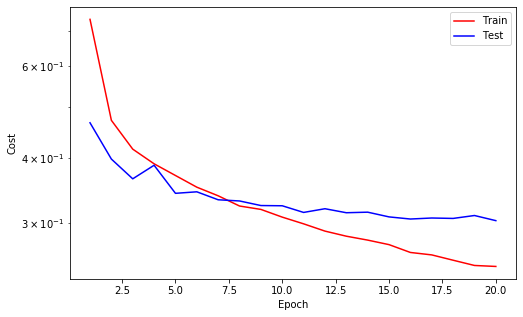

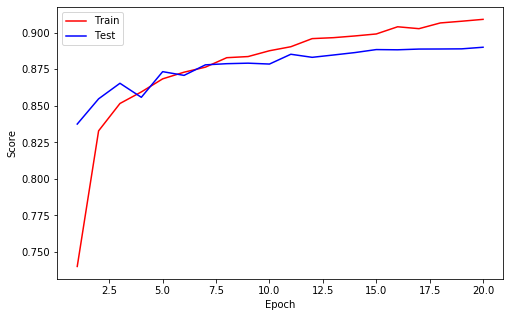



Epoch    21
Train_cost  = 0.2412 | Test_cost  = 0.3061 | Train_score = 0.9096 | Test_score = 0.8907 |




Epoch    22
Train_cost  = 0.2387 | Test_cost  = 0.3045 | Train_score = 0.9102 | Test_score = 0.8920 |




Epoch    23
Train_cost  = 0.2329 | Test_cost  = 0.3079 | Train_score = 0.9125 | Test_score = 0.8902 |
==> EarlyStop patience =  1 | Best test_score: 0.8920




Epoch    24
Train_cost  = 0.2290 | Test_cost  = 0.3148 | Train_score = 0.9157 | Test_score = 0.8898 |
==> EarlyStop patience =  2 | Best test_score: 0.8920




Epoch    25
Train_cost  = 0.2252 | Test_cost  = 0.3113 | Train_score = 0.9143 | Test_score = 0.8881 |
==> EarlyStop patience =  3 | Best test_score: 0.8920




Epoch    26
Train_cost  = 0.2231 | Test_cost  = 0.3161 | Train_score = 0.9173 | Test_score = 0.8871 |
==> EarlyStop patience =  4 | Best test_score: 0.8920




Epoch    27
Train_cost  = 0.2211 | Test_cost  = 0.3079 | Train_score = 0.9180 | Test_score = 0.8929 |




Epoch    28
Train_cost  = 0.2158 | Test_cost  = 0.2998 | Train_score = 0.9178 | Test_score = 0.8935 |




Epoch    29
Train_cost  = 0.2145 | Test_cost  = 0.3166 | Train_score = 0.9191 | Test_score = 0.8941 |




Epoch    30
Train_cost  = 0.2064 | Test_cost  = 0.3114 | Train_score = 0.9222 | Test_score = 0.8934 |
==> EarlyStop patience =  1 | Best test_score: 0.8941




Epoch    31
Train_cost  = 0.2059 | Test_cost  = 0.3195 | Train_score = 0.9236 | Test_score = 0.8909 |
==> EarlyStop patience =  2 | Best test_score: 0.8941




Epoch    32
Train_cost  = 0.2076 | Test_cost  = 0.3177 | Train_score = 0.9227 | Test_score = 0.8921 |
==> EarlyStop patience =  3 | Best test_score: 0.8941




Epoch    33
Train_cost  = 0.2000 | Test_cost  = 0.3121 | Train_score = 0.9252 | Test_score = 0.8938 |
==> EarlyStop patience =  4 | Best test_score: 0.8941




Epoch    34
Train_cost  = 0.2027 | Test_cost  = 0.3188 | Train_score = 0.9240 | Test_score = 0.8951 |




Epoch    35
Train_cost  = 0.1982 | Test_cost  = 0.3214 | Train_score = 0.9262 | Test_score = 0.8943 |
==> EarlyStop patience =  1 | Best test_score: 0.8951




Epoch    36
Train_cost  = 0.1947 | Test_cost  = 0.3245 | Train_score = 0.9279 | Test_score = 0.8936 |
==> EarlyStop patience =  2 | Best test_score: 0.8951




Epoch    37
Train_cost  = 0.1908 | Test_cost  = 0.3183 | Train_score = 0.9292 | Test_score = 0.8946 |
==> EarlyStop patience =  3 | Best test_score: 0.8951




Epoch    38
Train_cost  = 0.1905 | Test_cost  = 0.3346 | Train_score = 0.9278 | Test_score = 0.8928 |
==> EarlyStop patience =  4 | Best test_score: 0.8951




Epoch    39
Train_cost  = 0.1854 | Test_cost  = 0.3178 | Train_score = 0.9302 | Test_score = 0.8940 |
==> EarlyStop patience =  5 | Best test_score: 0.8951
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.8951
==> Best model is saved at model


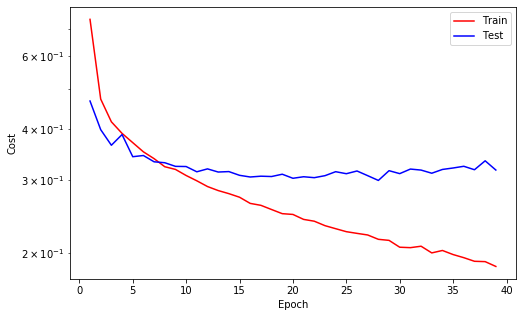

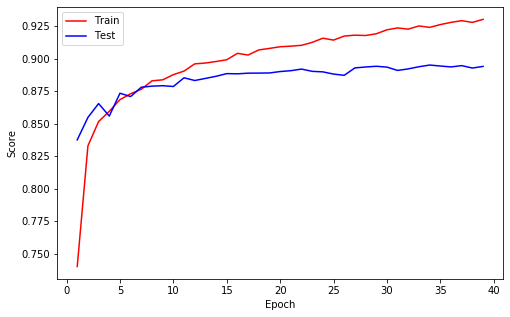

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device )
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Load best model

In [18]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
model.load_state_dict(weights)
model = model.to(device)

In [19]:
model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
)

## Predict

In [21]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Coat',
 'Pullover',
 'Trouser',
 'Bag',
 'Ankle boot',
 'Coat',
 'Dress',
 'Coat',
 'Bag',
 'Dress',
 'Bag',
 'Ankle boot',
 'Shirt',
 'Shirt',
 'Trouser',
 'Sneaker',
 'Shirt',
 'Shirt',
 'T-shirt or Top',
 'Sneaker',
 'Pullover',
 'Ankle boot',
 'Dress',
 'Sneaker',
 'Pullover',
 'Bag',
 'Pullover',
 'Dress',
 'Sandal',
 'Ankle boot',
 'Trouser',
 'T-shirt or Top',
 'Sandal',
 'T-shirt or Top',
 'Dress',
 'Bag',
 'Coat',
 'Shirt',
 'Trouser',
 'Dress',
 'Coat',
 'Sneaker',
 'Ankle boot',
 'T-shirt or Top',
 'Sneaker',
 'Sneaker',
 'T-shirt or Top',
 'Coat',
 'Dress',
 'T-shirt or Top',
 'Dress',
 'Ankle boot',
 'Coat',
 'Sneaker',
 'Shirt',
 'T-shirt or Top',
 'Bag',
 'Ankle boot',
 'Shirt',
 'Coat',
 'Dress',
 'Shirt',
 'Coat',
 'T-shirt or Top',
 'Sneaker',
 'Dress',
 'Coat',
 'Coat',
 'Bag',
 'Pullover',
 'Shirt',
 'Trouser',
 'Ankle boot',
 'Dress',
 'Sneaker',
 'Coat',
 'T-shirt or Top',
 'Ankle boot',
 'Shirt',
 'Bag',
 'Coat',
 'Shirt',
 'Shirt',
 'Bag',
 'Pullover',
 'Coat'

## Visualisasi

In [24]:
import matplotlib.pyplot as plt

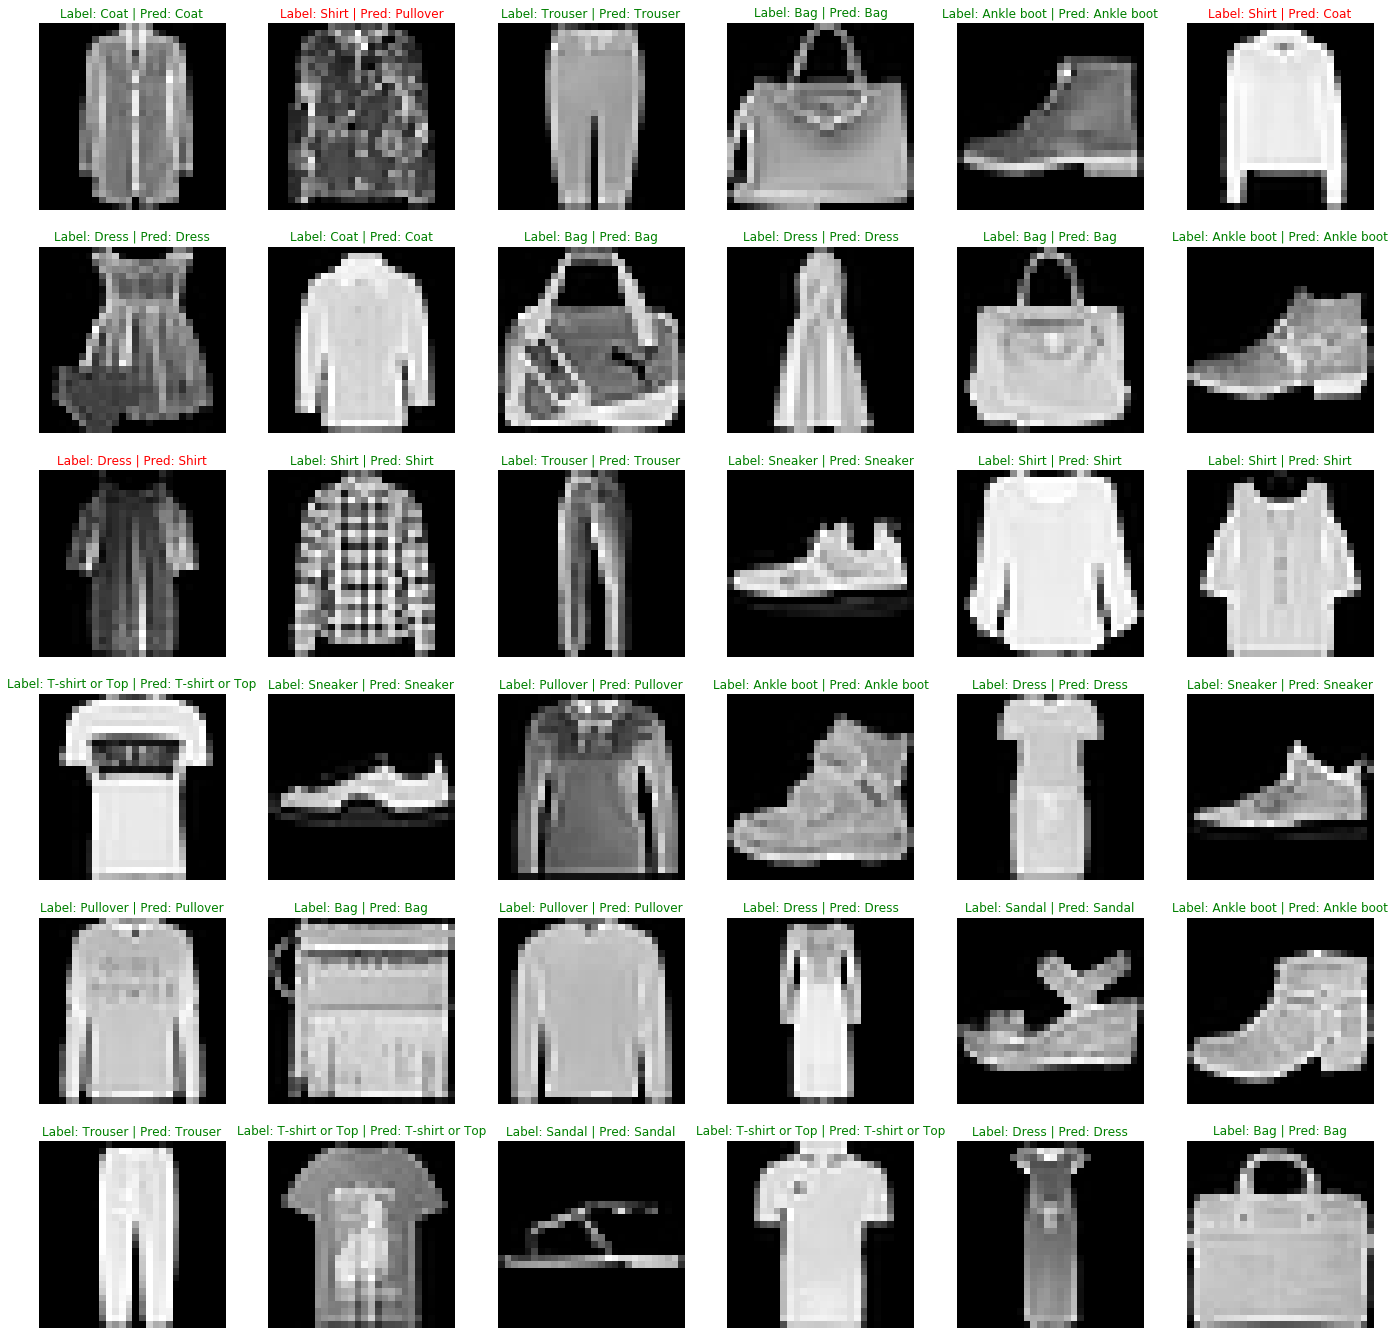

In [28]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');